In [1]:
import scanpy as sc
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import seaborn as sns

In [2]:
nsclc = sc.read_h5ad('/Users/meenasubramaniam/Downloads/99040b08-7e1a-4d81-911c-4d2fd2335757.h5ad')

In [3]:
tumor = nsclc[nsclc.obs['cell_type_major'] == "Tumor cells"]
nsclc.obs.to_csv('nsclc_covs.csv')


# del nsclc
# import gc
# gc.collect()

df = pd.DataFrame(tumor.layers['count'].toarray(), columns= tumor.var['feature_name'].values, index = tumor.obs.index)
covs = ['sample', 'disease', 'cell_type_major']
df = pd.concat([df, tumor.obs[covs]], ignore_index=True, axis = 1)


0

In [14]:
cell_sums = df.groupby(covs,observed = True).sum()
cell_sums.to_csv('cell_sums_tumor.csv')

In [25]:
counts = cell_sums.reset_index(drop=True)
mdata = cell_sums.reset_index()[covs]

In [40]:
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    counts=counts.astype(int)[counts.sum(axis =1) > 5000],
    metadata=mdata[counts.sum(axis =1) > 5000],
    design_factors='disease',
    refit_cooks=True,
    inference=inference,
    )
dds.deseq2()

/Users/meenasubramaniam/Documents/cor_test/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Fitting size factors...
... done in 0.20 seconds.

Fitting dispersions...
... done in 10.32 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 8.41 seconds.

Fitting LFCs...
... done in 7.77 seconds.

Calculating cook's distance...
... done in 0.94 seconds.

Replacing 3835 outlier genes.

Fitting dispersions...
... done in 2.09 seconds.

Fitting MAP dispersions...
... done in 1.70 seconds.

Fitting LFCs...
... done in 1.90 seconds.



In [46]:
norm = dds.layers['normed_counts']

In [68]:
mat = pd.DataFrame(norm, index = dds.obs['sample'].values, columns = dds.var_names)

In [54]:
tumor = pd.read_csv('nsclc_covs.csv', index_col = 0)

/var/folders/ml/kw8m8dss5zl1sv80nt5j4_7r0000gp/T/ipykernel_15790/944750917.py:1: DtypeWarning: Columns (3,9,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor = pd.read_csv('nsclc_covs.csv', index_col = 0)


In [63]:
ct_props = nsclc.obs.groupby(['sample', 'disease'])['cell_type_major'].value_counts(normalize = True).unstack(fill_value=0).reset_index()

In [77]:
mat_full = mat.merge(ct_props, how = 'left', left_index = True, right_on = 'sample')

In [84]:
diseases = ['normal', 'lung adenocarcinoma']
mat_use = mat_full.query("disease in @diseases" )
gene_mat = mat_use[mat.columns]
ct_prop = pd.Series(mat_use['T cell CD8'])
covariate = mat_use['disease'].replace({'normal':0, 'lung adenocarcinoma': 1})


In [93]:
from cor_test import *

In [118]:
ct_prop_scaled = center_scale(ct_prop, covariate)

In [ ]:
res =cor_test_all(gene_mat, ct_prop = ct_prop_scaled, covariate = covariate)

In [136]:
res.sort_values('P>|t|')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
WTAP,0.190524,0.050782,3.751820,0.000211,0.090585,0.290464
ACLY,0.272679,0.073110,3.729696,0.000230,0.128797,0.416560
SLC38A2,0.188583,0.052036,3.624086,0.000341,0.086175,0.290990
MTPAP,0.159783,0.044215,3.613763,0.000355,0.072767,0.246799
MAP3K1,0.158648,0.044839,3.538187,0.000468,0.070405,0.246892
...,...,...,...,...,...,...
ESYT3,-0.000075,0.137801,-0.000542,0.999568,-0.271269,0.271120
TOR1B,-0.000024,0.126594,-0.000192,0.999847,-0.249163,0.249114
YWHAH,-0.000018,0.126165,-0.000140,0.999888,-0.248311,0.248276
TRAV14DV4,0.000000,0.000000,NaN,NaN,0.000000,0.000000


[(0.0, 1500.0)]

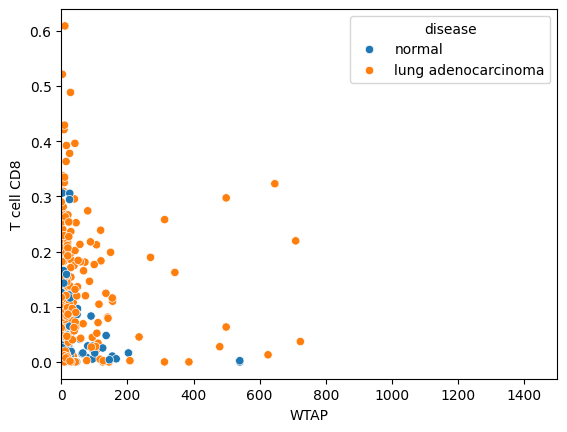

In [143]:
g = sns.scatterplot(mat_use, x = 'WTAP', y = 'T cell CD8', hue = 'disease')
g.set(xlim=(0, 1500))